# Lab4: Constrained optimization: equality and inequality constraints

**Carla Sendra Balcells**\
**Roxane Le Tensorer**\
**Rachel Trimble**

In [108]:
import numpy as np
import matplotlib.pyplot as plt
from QPGC import *
import tqdm

The problem we want to solve is the following one:

Minimize $f(\alpha)=\sum_{i=1}^{m} -\alpha_i + \dfrac{1}{2} \alpha^T(YX^T XY)\alpha  $<br>
Subject to $\sum_{i=1}^{m} y_i \alpha_i = 0 \;\;\;,\;\;\;0 \leq \alpha_i \leq K $<br>

But we will try to convert it to this notation:

Minimize $f(x)=\dfrac{1}{2} x^T G x + g^T x $<br>
Subject to $A^T x=b \;\;\;,\;\;\;C^T x \geq d$<br>

So, we could define:

$G = Y X^T XY$\
$x = \alpha$\
$g^T = -[1,1,...n]$\
$A = y$\
$b = 0$\
$C = Id$\
$d = K$

$G\in R^{nxn}$,
$x\in R^{n}$,
$g\in R^{n}$,
$A\in R^{nxp}$,
$C\in R^{nxm}$,
$b\in R^{p}$,
$d\in R^{m}$, 
$Y\in R^{nxn}$,
$y\in R^{n}$,
$X\in R^{mxn}$,
$\alpha \in R^{n}$,
$K \in R^{m}$

where n are the number of samples (n=200) and m the number of constraints (m=200x2), p=1. 

In [110]:
def generate_dataset(N, separable):
    m1 = [0, 0]
    s1 = [[1, -0.9], [-0.9, 1]]
    s2 = [[1, 0], [0, 1]]
    if separable:
        m2 = [3, 6]
    else:
        m2 = [1, 2]
    cluster_1 = np.random.multivariate_normal(m1, s1, N)
    cluster_2 = np.random.multivariate_normal(m2, s2, N)
    X = np.concatenate([cluster_1, cluster_2]).T
    Y = np.diag(np.concatenate([np.ones(cluster_1.shape[0]), -np.ones(cluster_2.shape[0])]))
    return X, Y, cluster_1, cluster_2

In [113]:
def plot_both_clusters(N):
    _, _, c1s, c2s = generate_dataset(N,True)
    _, _, c1n, c2n = generate_dataset(N, separable=False)

    fig = plt.figure(figsize=(12, 4))
    ax = fig.add_subplot(121)
    ax.plot(c1s[:, 0], c1s[:, 1], marker='o', linestyle='None', alpha=0.7)
    ax.plot(c2s[:, 0], c2s[:, 1], marker='o',linestyle='None', alpha=0.7)
    ax.set_title("Separable problem")

    ax = fig.add_subplot(122)
    ax.plot(c1n[:, 0], c1n[:, 1], marker='o', linestyle='None', alpha=0.7)
    ax.plot(c2n[:, 0], c2n[:, 1], marker='o',linestyle='None', alpha=0.7)
    ax.set_title("Non-separable problem")


    plt.show()

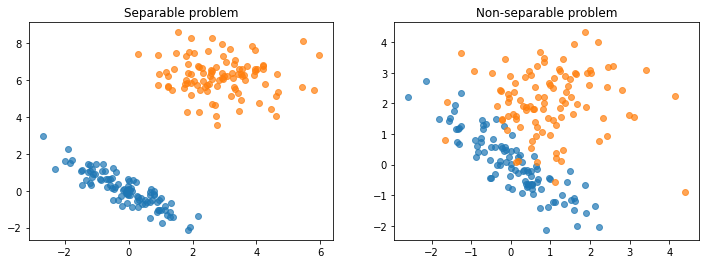

In [114]:
plot_both_clusters(100)

## Separable Dataset

### 1. Simple case (N=2)

In [115]:
N=2
X, Y, cluster1, cluster2 = generate_dataset(N,True)
X.shape, Y.shape, cluster1.shape, cluster2.shape

((2, 4), (4, 4), (2, 2), (2, 2))

We define a function "param" to convert X, Y into the desired notation in order to compile the dual problem.

In [116]:
def param(X, Y, K=1):
    n = X.shape[1]
    m = 2*n
    
    G = np.dot(np.dot(np.dot(Y,X.T),X),Y)
    g = -np.ones(n)
    A = np.expand_dims(np.diag(Y), axis=0).T
    b = np.zeros(1)
    C = np.eye(n, m)
    d = np.zeros(m)*K
    
    return G, g, A, C, b, d

In [117]:
G, g, A, C, b, d = param(X, Y, K=1)
G.shape, g.shape, A.shape, C.shape, b.shape, d.shape

((4, 4), (4,), (4, 1), (4, 8), (1,), (8,))

Once the dual problem has been solved and the optimal value of $\alpha$ is acquired, the parameters $w$ and $b$ can be solved utilizing the below formulas: <br>

$w = \sum_{i=1}^m\alpha_iy_ix_i$\
$b = \frac{1}{y_j}-w^Tx_j$

where $\alpha \in R^2$ and $b\in R^1$

Moreover, $x_j$ and $y_j$ are the ones with the $\alpha$ that gets a higher minimization at $f(\alpha)$, for this reason $\alpha_j$ should be the one with a highest value. 

In [118]:
def sol(X, Y, alpha):
    w = np.dot(X,np.diag(alpha*Y))
    j = np.argmax(alpha)
    b = Y[j,j]-np.dot(w,X[:,j])
    return w,b

In [119]:
def plot_svm(cluster_1,cluster_2, w, b): 

    x_plot,y_plot = np.meshgrid(np.linspace(-5,7,100),np.linspace(-4,10,100))
    mesh = np.c_[x_plot.ravel(),y_plot.ravel()]     
    z = np.dot(mesh,w)+b
        
    plt.plot(cluster_1[:,0],cluster_1[:,1],color='c', marker='o', linestyle='None', alpha=0.7)
    plt.plot(cluster_2[:,0],cluster_2[:,1],color='orange', marker='o',linestyle='None', alpha=0.7)
    plt.contour(x_plot,y_plot,z.reshape((100,100)),[-1.,0.,1.])

    plt.show()

We now run the algorithm, setiing the parameter k as 1.

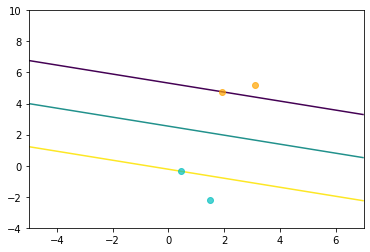

w:[-0.10460663 -0.36053005] b:0.9171295423591366


In [120]:
K=1

G, g, A, C, b, d = param(X, Y, K)
alpha = QPGenericConstraints(G, g, A, C, b, d)

w, b = sol(X, Y, alpha)

plot_svm(cluster1, cluster2, w, b)
print('w:'+str(w)+' b:'+str(b))

We observe that there is a critical subset of data points. These are called Support Vectors. If any of those points disappear the boundary changes. The "maximum-margin hyperplane" formed from these support vectors divides the clusters for which $y_i=1$ from the group of points for which $y_i=-1$, which is defined so that the distance between the hyperplane and the nearest point from either group is maximized. 

The algorithm seems to have been succesful at separating the separable data into two distinct groups.

### 2. Simple case (N=100)

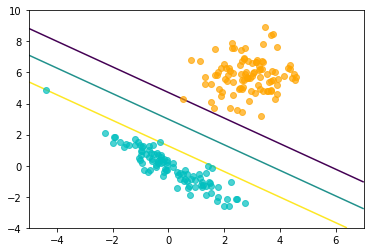

w:[-0.47881825 -0.58101728] b:1.737818467969634


In [123]:
N=100
X, Y, cluster1, cluster2 = generate_dataset(N,True)
G, g, A, C, b, d = param(X, Y, K)
alpha = QPGenericConstraints(G, g, A, C, b, d)

w, b = sol(X, Y, alpha)

plot_svm(cluster1, cluster2, w, b)
print('w:'+str(w)+' b:'+str(b))

The algorithm is successful at dividing the dataset into two distinct groups. 

### 3. Testing different values for $K$

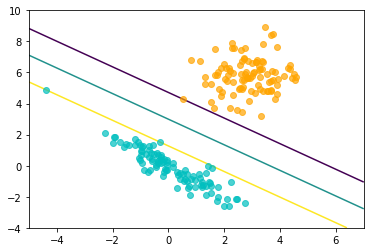

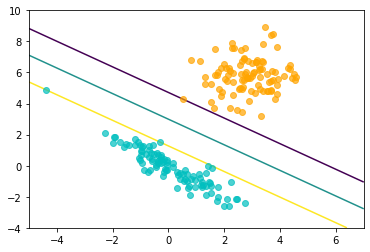

In [124]:
fig = plt.figure()

K=10**6
G, g, A, C, b, d = param(X, Y, K)
alpha = QPGenericConstraints(G, g, A, C, b, d)
w, b = sol(X, Y, alpha)
plot_svm(cluster1, cluster2, w, b)

K=10**12
G, g, A, C, b, d = param(X, Y, K)
alpha = QPGenericConstraints(G, g, A, C, b, d)
w, b = sol(X, Y, alpha)
plot_svm(cluster1, cluster2, w, b)

plt.show()

The algorithm works for the larger values of K, this is because we are in the separable case, and since $\alpha$ is not bounded by $K$ in the separable case the result is consistent for all values of $K$

## Non Separable Dataset

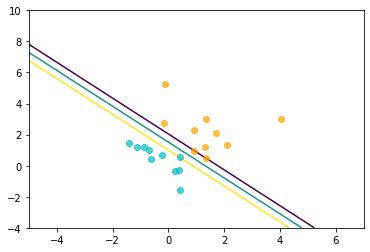

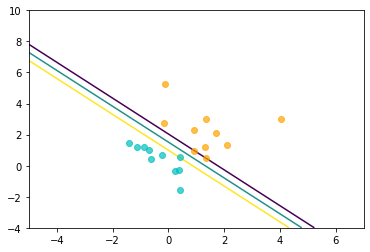

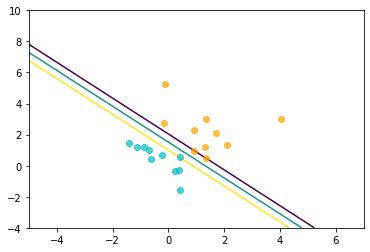

In [128]:
N=10
X, Y, cluster1, cluster2 = generate_dataset(N,False)

K=1
G, g, A, C, b, d = param(X, Y, K)
alpha = QPGenericConstraints(G, g, A, C, b, d)
w, b = sol(X, Y, alpha)
plot_svm(cluster1, cluster2, w, b)

K=10**6
G, g, A, C, b, d = param(X, Y, K)
alpha = QPGenericConstraints(G, g, A, C, b, d)
w, b = sol(X, Y, alpha)
plot_svm(cluster1, cluster2, w, b)

K=10**12
G, g, A, C, b, d = param(X, Y, K)
alpha = QPGenericConstraints(G, g, A, C, b, d)
w, b = sol(X, Y, alpha)
plot_svm(cluster1, cluster2, w, b)

plt.show()